# 05. Переобучение, выбор модели, регуляризация и валидация

В этом блокноте мы разберём:
- понятия **недообучения** и **переобучения**;
- разделение на **train/validation/test**;
- идею **кросс-валидации**;
- **регуляризацию** (L2 как пример);
- практический пример с полиномиальной регрессией.

## 1. Недообучение и переобучение

Модель должна **хорошо работать на новых данных**, а не только на тех, на которых её обучали.

- **Недообучение (underfitting)** — модель слишком простая, не улавливает закономерности.
  - Плохое качество и на обучении, и на тесте.
- **Переобучение (overfitting)** — модель слишком сложная, «запоминает» обучающую выборку, в том числе шум.
  - Отличное качество на обучении, но заметно хуже на тесте.

Наша цель — найти **баланс** между сложностью модели и её способностью обобщать (компромисс bias–variance).

## 2. Разделение на train/validation/test

Чтобы честно оценивать качество модели, данные обычно делят на:

- **train** — обучение модели;
- **validation** — подбор гиперпараметров и выбор лучшей модели;
- **test** — финальная проверка качества (не трогаем до самого конца).

Иногда используют только train и test, но при этом подбирают гиперпараметры по тесту — это приводит к завышенной оценке качества.

Более надёжный способ — **кросс-валидация**.

## 3. Кросс-валидация (k-fold CV)

Идея:
- делим обучающую выборку на $k$ блоков (фолдов),
- $k-1$ фолдов используем для обучения, оставшийся — для валидации,
- повторяем процедуру $k$ раз, каждый раз меняя валидационный фолд,
- усредняем качество по всем фолдам.

Так мы получаем более устойчивую оценку качества и лучше используем данные.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score

plt.style.use("seaborn-v0_8-whitegrid")

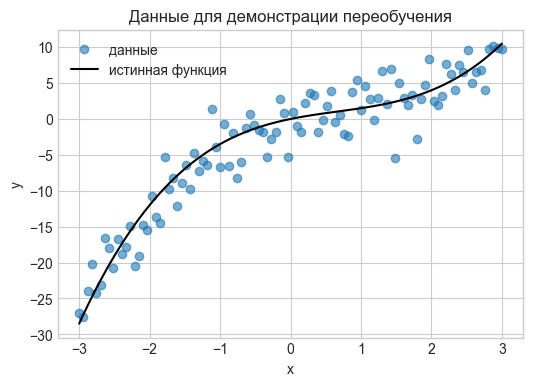

In [2]:
# Сгенерируем данные с нелинейной зависимостью

np.random.seed(42)

n_samples = 100
X = np.linspace(-3, 3, n_samples).reshape(-1, 1)

y_true_func = lambda x: 0.5 * x**3 - x**2 + 2 * x
noise = np.random.normal(0, 3.0, size=n_samples)

y = y_true_func(X[:, 0]) + noise

plt.figure(figsize=(6, 4))
plt.scatter(X, y, alpha=0.6, label="данные")
plt.plot(X, y_true_func(X[:, 0]), color="black", label="истинная функция")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Данные для демонстрации переобучения")
plt.show()

In [3]:
# Разобьём на train и test

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print("Размер train:", X_train.shape[0])
print("Размер test:", X_test.shape[0])

Размер train: 70
Размер test: 30


In [4]:
# Функция для обучения полиномиальной регрессии заданной степени и оценки ошибок

def fit_and_evaluate_poly(degree, model_cls=LinearRegression, **model_kwargs):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    model = model_cls(**model_kwargs)
    model.fit(X_train_poly, y_train)

    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    return train_mse, test_mse, model, poly

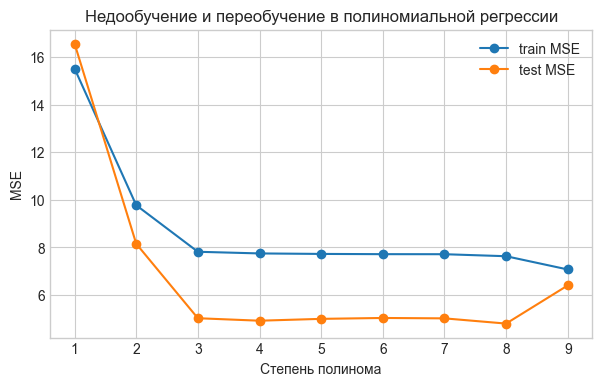

In [5]:
degrees = range(1, 10)
train_errors = []
test_errors = []

for d in degrees:
    train_mse, test_mse, _, _ = fit_and_evaluate_poly(d)
    train_errors.append(train_mse)
    test_errors.append(test_mse)

plt.figure(figsize=(7, 4))
plt.plot(degrees, train_errors, marker="o", label="train MSE")
plt.plot(degrees, test_errors, marker="o", label="test MSE")
plt.xlabel("Степень полинома")
plt.ylabel("MSE")
plt.title("Недообучение и переобучение в полиномиальной регрессии")
plt.legend()
plt.show()

На графике обычно видно, что:
- при малых степенях (1–2) модель недообучена (большая ошибка и на train, и на test),
- при слишком больших степенях train-ошибка падает почти до нуля, но test-ошибка снова растёт (переобучение),
- существует некоторая «оптимальная» степень, дающая наименьшую test-ошибку.

## 4. Регуляризация (на примере L2 / Ridge)

Идея регуляризации — **штрафовать слишком большие коэффициенты** модели, чтобы предотвратить переобучение и сделать модель более устойчивой.

В случае L2-регуляризации (Ridge-регрессия) функция потерь имеет вид:

$$
L(w) = \frac{1}{n} \sum_{i=1}^n (y^{(i)} - \hat{y}^{(i)})^2 + \alpha \|w\|_2^2,
$$

где $\alpha > 0$ — коэффициент регуляризации.

- При больших $\alpha$ модель становится проще (коэффициенты ближе к нулю).
- При $\alpha = 0$ получаем обычную линейную регрессию без регуляризации.

Регуляризацию можно интерпретировать как добавление априорного предположения, что «хорошая» модель не должна иметь слишком большие веса.

Степень полинома: 9
LinearRegression train MSE: 7.071170345226999
LinearRegression test MSE: 6.401435007315912
Ridge train MSE: 7.636139997302655
Ridge test MSE: 5.538080513131407


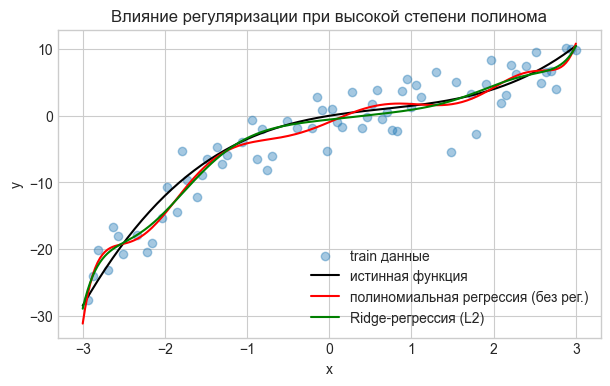

In [6]:
# Сравним обычную полиномиальную регрессию и Ridge при большой степени

degree = 9

train_mse_lin, test_mse_lin, model_lin, poly = fit_and_evaluate_poly(degree, model_cls=LinearRegression)
train_mse_ridge, test_mse_ridge, model_ridge, _ = fit_and_evaluate_poly(degree, model_cls=Ridge, alpha=10.0)

print(f"Степень полинома: {degree}")
print("LinearRegression train MSE:", train_mse_lin)
print("LinearRegression test MSE:", test_mse_lin)
print("Ridge train MSE:", train_mse_ridge)
print("Ridge test MSE:", test_mse_ridge)

# Визуализируем
X_plot = np.linspace(-3, 3, 200).reshape(-1, 1)
X_plot_poly = poly.transform(X_plot)

y_lin = model_lin.predict(X_plot_poly)
y_ridge = model_ridge.predict(X_plot_poly)

plt.figure(figsize=(7, 4))
plt.scatter(X_train, y_train, alpha=0.4, label="train данные")
plt.plot(X_plot, y_true_func(X_plot[:, 0]), color="black", label="истинная функция")
plt.plot(X_plot, y_lin, color="red", label="полиномиальная регрессия (без рег.)")
plt.plot(X_plot, y_ridge, color="green", label="Ridge-регрессия (L2)")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Влияние регуляризации при высокой степени полинома")
plt.show()

## 5. Задания

**Теория**

1. Объясните своими словами, чем отличается недообучение от переобучения.
2. Зачем нужно делить данные на train/validation/test? Что может пойти не так, если использовать только train и test и подбирать гиперпараметры по test?
3. В чём интуитивный смысл L2-регуляризации? Как влияет параметр $\alpha$?

**Практика**

1. Поэкспериментируйте со степенью полинома (например, от 1 до 15) и постройте графики train/test MSE. Найдите степень, при которой test-ошибка минимальна.
2. Измените коэффициент `alpha` в Ridge-регрессии (например, 0.1, 1.0, 10.0, 100.0) и посмотрите, как меняются ошибки и форма приближающей функции.
3. Попробуйте использовать кросс-валидацию (`cross_val_score`) для выбора лучшей степени полинома (или лучшего `alpha`).

После выполнения этого ноутбука у вас будет базовое понимание того, как строить и оценивать модели, избегая переобучения и подбирая подходящий уровень сложности.

### Решения: теория

1. **Недообучение** — модель слишком простая, плохо описывает зависимость (высокая ошибка и на train, и на test). **Переобучение** — модель подстроилась под обучающую выборку и шум (низкая ошибка на train, высокая на test).

2. **Train** — обучение, **validation** — подбор гиперпараметров, **test** — финальная оценка. Если подбирать гиперпараметры по test, мы «подгоняемся» под тест, и оценка качества становится оптимистичной (data leakage).

3. **L2-регуляризация** штрафует большие по модулю веса, делая модель проще и устойчивее. Рост $\\alpha$ усиливает штраф → веса ближе к нулю, модель проще; при $\\alpha$ слишком большом — недообучение.

Степень с минимальной test MSE: 8


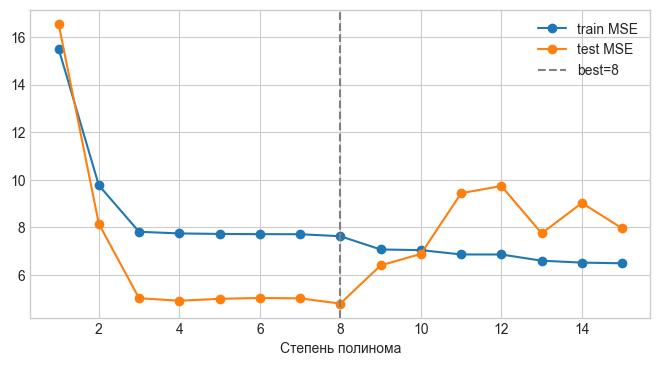

Лучшая степень по 5-fold CV (1..10): 3


In [7]:
# Решения: практика — степень полинома 1..15, поиск лучшей по test MSE
degrees = range(1, 16)
train_err, test_err = [], []
for d in degrees:
    te, tst, _, _ = fit_and_evaluate_poly(d)
    train_err.append(te)
    test_err.append(tst)
best_degree = degrees[np.argmin(test_err)]
print("Степень с минимальной test MSE:", best_degree)
plt.figure(figsize=(8, 4))
plt.plot(degrees, train_err, 'o-', label='train MSE')
plt.plot(degrees, test_err, 'o-', label='test MSE')
plt.axvline(best_degree, color='gray', linestyle='--', label=f'best={best_degree}')
plt.xlabel('Степень полинома')
plt.legend()
plt.show()

# Кросс-валидация для выбора степени (пример)
scores = [np.mean(cross_val_score(LinearRegression(), PolynomialFeatures(degree=d, include_bias=False).fit_transform(X_train), y_train, cv=5, scoring='neg_mean_squared_error')) for d in range(1, 11)]
best_cv = np.argmax(scores) + 1
print("Лучшая степень по 5-fold CV (1..10):", best_cv)